In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import faiss
import matplotlib.pyplot as plt
import numpy as np

from pose_data_db import PoseDataDatabase
from jupyter_helpers import show_video_selector

db = await PoseDataDatabase.create()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
video_selector = show_video_selector(await db.get_available_videos())
video_selector

Please select the video to explore from the dropdown list.

Dropdown(description='Video to explore:', layout=Layout(height='40px', width='60%'), options=(('Serso ato 3 (C…

In [3]:
normalized_pose_data = await db.get_pose_annotations("norm", video_selector.value)

In [4]:
# don't try to print `normalized_pose_data` to the screen!
len(normalized_pose_data)

86327

#### Optional: cluster analysis of normalized poses

The cell below computes a K-means clustering of the poses based on the L2 (Euclidean) similarities of their normalized coordinate vectors, then calculates and visualizes the relative sizes of the clusters and the averaged armature positions of their poses.

The averaged poses are visualized on blended averages of their background (source) image regions if `AVERAGE_BACKGROUNDS` is set to `True` -- although generating these plots takes quite a bit longer than plotting averaged poses with no backgrounds, due to the overhead of averaging the background images' pixel values.

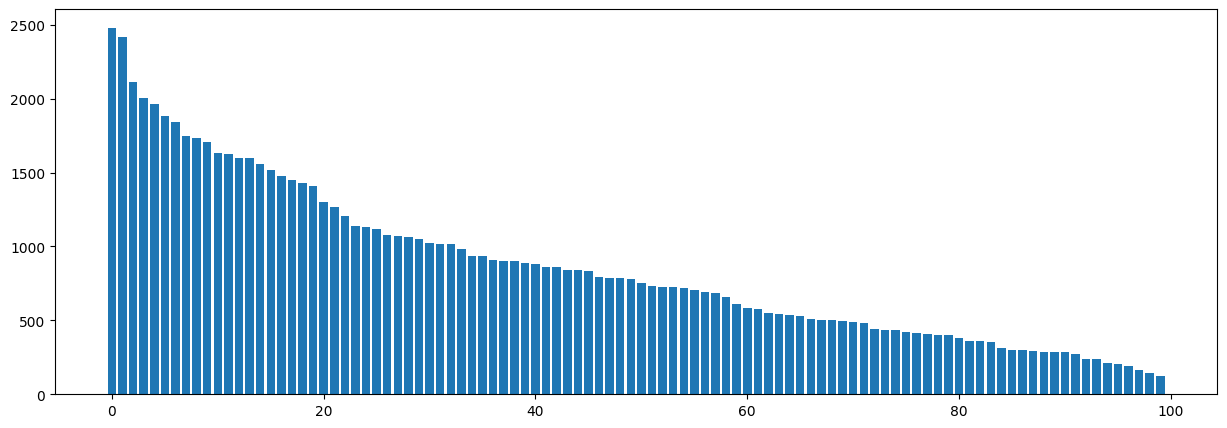

In [5]:
# +
faiss_L2_input = np.array(normalized_pose_data).astype("float32")

kmeans_faiss = faiss.Kmeans(d=faiss_L2_input.shape[1], k=100, niter=100)
kmeans_faiss.train(faiss_L2_input)
_, cluster_labels = kmeans_faiss.index.search(faiss_L2_input, 1)
cluster_labels = np.array(cluster_labels).flatten()

bin_counts = defaultdict(int)
cluster_to_pose = defaultdict(list)

for i, ct in enumerate(cluster_labels):
    bin_counts[ct] += 1
    cluster_to_pose[ct].append(i)

sorted_bin_counts = sorted(bin_counts.values(), reverse=True)

plt.rcParams["figure.figsize"] = (15,5)
plt.bar(range(len(sorted_bin_counts)), sorted_bin_counts)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]